In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

rng = np.random.default_rng(seed=42)

In [39]:
# === Market Share Simulation Based on Pitney Bowes Parcel Shipping Index ===
# Source: https://www.pitneybowes.com/de/newsroom/pressemitteilungen/2023-parcel-shipping-index.html
# 
# According to volume (as of 2022), DHL holds the largest market share at 49%,
# followed by Hermes (13%), UPS (12%), DPD (11%), GLS (8%), and FedEx/TNT (6%).
# The percentage change in market share between 2016 and 2022 was:
# - DHL: +6.0%
# - Hermes: –1.5%
# - UPS: +0.2%
# - DPD: –0.5%
# - GLS: +1.0%
# - FedEx/TNT: –0.2%

# --- Given Market Share Data for 2022 (% of parcel volume) ---
data_2022 = {
    "Year": 2022,
    "DHL": 49,
    "Hermes": 13,
    "UPS": 12,
    "DPD": 11,
    "GLS": 8,
    "FedEx/TNT": 6
}

# --- Net change in market share from 2016 to 2022 (% points) ---
growth = {
    "DHL": 6,
    "Hermes": -1.5,
    "UPS": 0.2,
    "DPD": -0.5,
    "GLS": 1,
    "FedEx/TNT": -0.2,
}

# --- Back-calculate market share for 2016 using growth data ---
data_2016 = {"Year": 2016}
for company, change in growth.items():
    data_2016[company] = data_2022[company] - change

# --- Create base DataFrame for years 2014–2050 ---
years = list(range(2014, 2051))
df_market = pd.DataFrame({"Year": years})

# --- Calculate annual change between 2016 and 2022 (linear growth/decline per year) ---
years_diff = 2022 - 2016
annual_change = {company: change / years_diff for company, change in growth.items()}

# --- Project market shares backward to 2014 and forward to 2050 with damping factor ---
for company in data_2022.keys():
    if company == "Year":
        continue  # Skip the year key
    values = []
    for year in years:
        if year < 2016:
            # Backward projection (pre-2016) using inverted linear growth
            value = data_2016[company] - annual_change[company] * (2016 - year)
        elif year <= 2022:
            # Linear interpolation between 2016 and 2022 values
            value = data_2016[company] + (data_2022[company] - data_2016[company]) * (year - 2016) / years_diff
        else:
            # Post-2022 projection with damping — assumes slower change over time
            delta_years = year - 2022
            damping = 1 / np.sqrt(delta_years + 1)  # Decreasing impact over time
            value = values[-1] + annual_change.get(company, 0) * damping * 2.25  # Smoothed progression
        values.append(value)
    df_market[company] = values

# --- Normalize all shares to sum to 100% per year ---
categories = ["DHL", "Hermes", "UPS", "DPD", "GLS", "FedEx/TNT"]
df_market_sum = df_market[categories].sum(axis=1)

# Convert absolute shares to percentage format (normalize row-wise)
df_market[categories] = df_market[categories].div(df_market_sum, axis=0) * 100


In [40]:
# === Define realistic corporate brand colors for each parcel carrier ===
COLORS = {
    "DHL": "#FFCC00",         # Bright yellow (official DHL brand color)
    "Hermes": "#009FE3",      # Hermes light blue (from logo)
    "UPS": "#351C15",         # UPS brown (classic brand identity)
    "DPD": "#E30613",         # DPD red (official brand red)
    "GLS": "#002C77",         # GLS dark blue (from corporate logo)
    "FedEx/TNT": "#FF6600",   # Orange (TNT/FedEx shipping division)
    "Amazon": "#232F3E"       # Amazon orange (from smile logo & web branding)
}

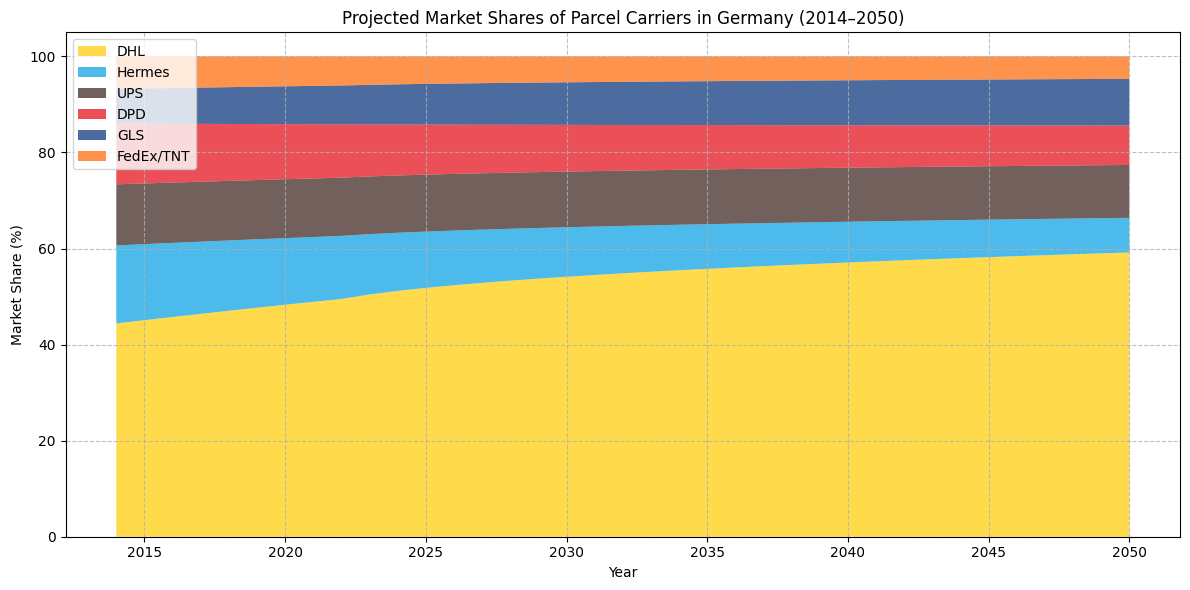

In [41]:
# === Plot: Stacked Area Chart of Market Share Forecasts (2014–2050) ===
plt.figure(figsize=(12, 6))  # Set figure size (width x height in inches)

# Create a stacked area chart
plt.stackplot(
    df_market["Year"],                                     # X-axis: years
    [df_market[cat] for cat in categories],                # Y-values: each carrier's market share over time
    labels=categories,                                     # Legend labels
    colors=[COLORS[cat] for cat in categories],            # Use corporate colors defined above
    alpha=0.7                                              # Transparency for better layering
)

# Axis labels and chart title
plt.xlabel("Year")
plt.ylabel("Market Share (%)")
plt.title("Projected Market Shares of Parcel Carriers in Germany (2014–2050)")

# Add legend and grid
plt.legend(loc="upper left")              # Position legend in upper-left corner
plt.grid(True, linestyle="--", alpha=0.8) # Add subtle grid for readability

# Optimize layout and display the plot
plt.tight_layout()
plt.show()


C:\Users\bienzeisler\AppData\Local\Temp\ipykernel_12668\1094086176.py:54: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(sigmoid, amazon_years, amazon_shares, p0=initial_guess)


Fitted parameters: L = 22.45, x0 = 2020.19, k = 1.16


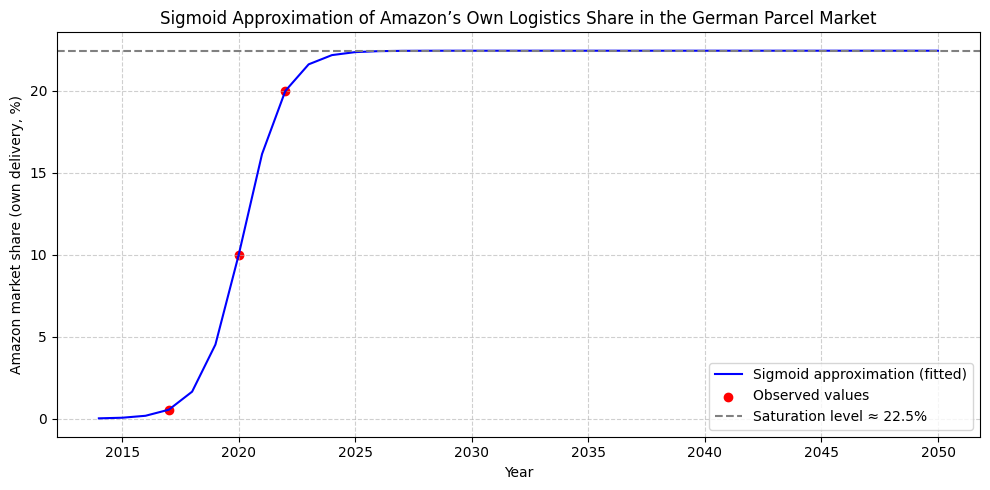

In [15]:
# === Sigmoid Approximation for Amazon's Market Share in Germany ===
# This script models Amazon's estimated parcel delivery market share using a sigmoid (logistic) curve.
#
# Data sources and assumptions:
# - 2017: 22 million Amazon shipments out of 4050 million total (~0.543%)
# - 2020: Estimated 5–15% → midpoint = 10%
# - 2022: Estimated 15–25% → midpoint = 20%
#
# Sources:
# - https://de.statista.com/statistik/daten/studie/893586/
# - https://www.wirtschaftsdienst.eu/inhalt/jahr/2022/heft/10/beitrag/amazon-und-der-deutsche-paketmarkt-wettbewerb-oder-marktmachthebelung.html
# - https://www.finanztreff.de/nachrichten/2023-12-13-amazon-holt-auf-platz-2-im-deutschen-paketmarkt-835156

# --- Step 1: Define the sigmoid (logistic) function ---
def sigmoid(x, L, x0, k):
    """
    Logistic sigmoid function for growth modeling.

    Parameters:
    ----------
    x : float or array-like
        Independent variable (e.g., year).
    L : float
        Maximum saturation level (% market share).
    x0 : float
        Inflection point — year of fastest growth.
    k : float
        Growth rate — controls curve steepness.

    Returns:
    --------
    float or array-like
        Estimated values of market share.
    """
    return L / (1 + np.exp(-k * (x - x0)))


# --- Step 2: Observed data points for Amazon's market share ---
amazon_years = np.array([2017, 2020, 2022])  # Years with data points
amazon_shares = np.array([
    22 / 4050 * 100,  # 2017: ≈ 0.543% of market
    10,               # 2020: midpoint of 5–15%
    20                # 2022: midpoint of 15–25%
])


# --- Step 3: Provide initial guesses for [L, x0, k] ---
# L = max market share (%), x0 = inflection year, k = curve steepness
initial_guess = [22, 2020, 1.1]


# --- Step 4: Fit the sigmoid model to the data using non-linear least squares ---
# Finds the optimal values for L, x0, and k based on the provided data points
popt, pcov = curve_fit(sigmoid, amazon_years, amazon_shares, p0=initial_guess)


# --- Step 5: Extract fitted parameters ---
L_fit, x0_fit, k_fit = popt
print(f"Fitted parameters: L = {L_fit:.2f}, x0 = {x0_fit:.2f}, k = {k_fit:.2f}")


# --- Step 6: Predict Amazon's market share from 2014 to 2050 using the fitted model ---
years_future = np.arange(2014, 2051)
amazon_predicted_sigmoid = sigmoid(years_future, *popt)

# === Plot the fitted sigmoid curve alongside observed values ===

plt.figure(figsize=(10, 5))

# Plot the fitted sigmoid curve
plt.plot(
    years_future,
    amazon_predicted_sigmoid,
    label="Sigmoid approximation (fitted)",
    color="blue"
)

# Plot the observed data points used for fitting
plt.scatter(
    amazon_years,
    amazon_shares,
    label="Observed values",
    color="red"
)

# Add a horizontal line indicating the saturation level (L)
plt.axhline(
    y=L_fit,
    color="gray",
    linestyle="dashed",
    label=f"Saturation level ≈ {L_fit:.1f}%"
)

# Labeling and plot configuration
plt.xlabel("Year")
plt.ylabel("Amazon market share (own delivery, %)")
plt.title("Sigmoid Approximation of Amazon’s Own Logistics Share in the German Parcel Market")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

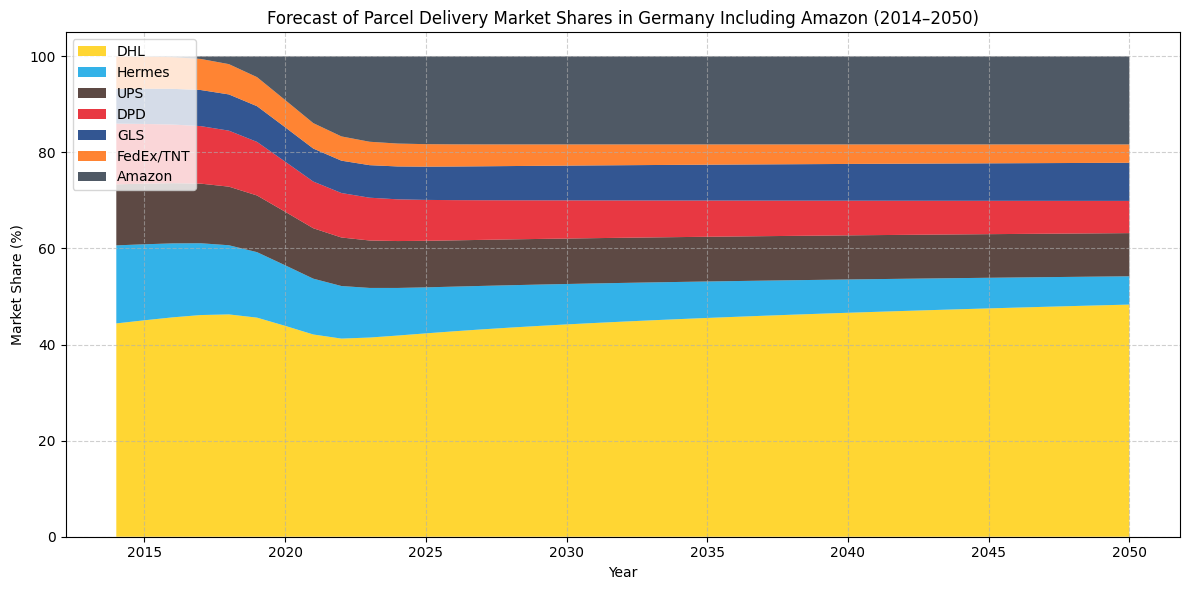

In [43]:
# === Estimate Amazon's Market Share Using Fitted Sigmoid Curve ===

# === Copy the Final DataFrame for Further Use or Export ===
df_marketshare_with_amazon = df_market.copy()

# Apply the fitted sigmoid function to project Amazon's market share
df_marketshare_with_amazon["Amazon"] = sigmoid(df_marketshare_with_amazon["Year"], L_fit, x0_fit, k_fit)

# Set Amazon's share to 0% in 2014 (not yet operating own logistics)
df_marketshare_with_amazon.loc[df_marketshare_with_amazon["Year"] == 2014, "Amazon"] = 0

# === List of All Parcel Delivery Companies (including Amazon) ===
all_categories = ["DHL", "Hermes", "UPS", "DPD", "GLS", "FedEx/TNT", "Amazon"]

# === Normalize Market Shares to Sum to 100% Per Year ===

# Calculate row-wise sum of all market shares
df_market_sum = df_marketshare_with_amazon[all_categories].sum(axis=1)

# Normalize each column so all categories sum to 100% per year
df_marketshare_with_amazon[all_categories] = df_marketshare_with_amazon[all_categories].div(df_market_sum, axis=0) * 100


# === Plot: Stacked Area Chart Including Amazon ===

plt.figure(figsize=(12, 6))

# Create stacked area plot for all parcel carriers including Amazon
plt.stackplot(
    df_marketshare_with_amazon["Year"],
    [df_marketshare_with_amazon[cat] for cat in all_categories],
    labels=all_categories,
    colors=[COLORS[cat] for cat in all_categories],
    alpha=0.8
)

# Plot labels and layout
plt.xlabel("Year")
plt.ylabel("Market Share (%)")
plt.title("Forecast of Parcel Delivery Market Shares in Germany Including Amazon (2014–2050)")
plt.legend(loc="upper left")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [44]:
# Export the DataFrame to a CSV file
df_marketshare_with_amazon.to_csv("output/00_markedshare_with_amazon.csv", index=False)

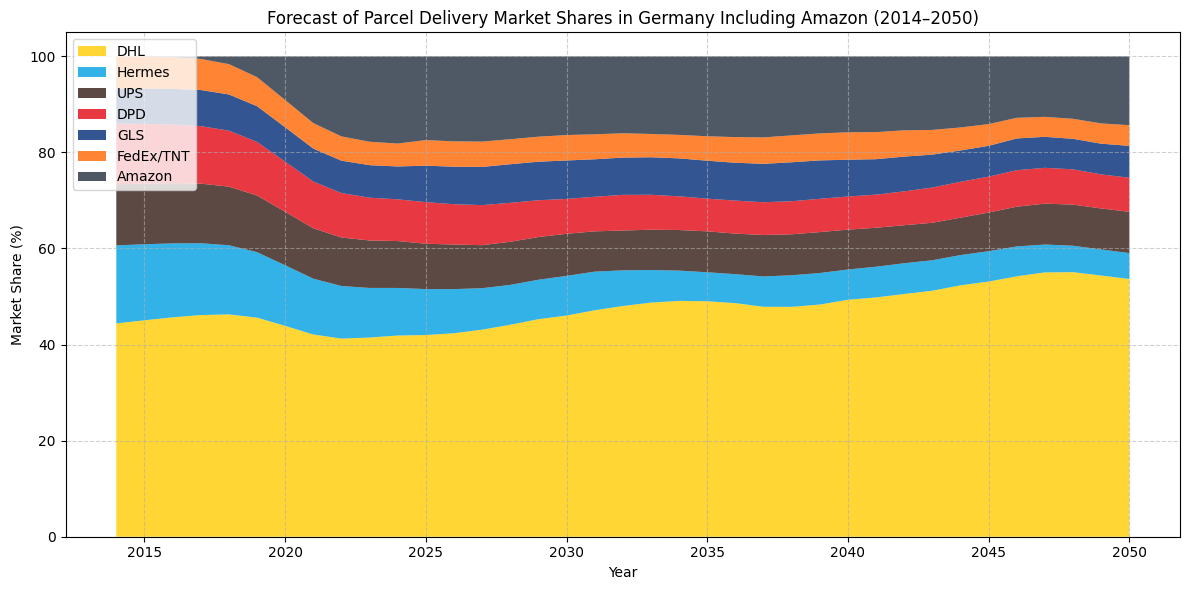

In [49]:
def simulate_market_uncertainty(
    df_base: pd.DataFrame,
    categories: list,
    start_year: int = 2025,
    uncertainty_level: float = 0.02,
) -> pd.DataFrame:
    """
    Simulate provider-specific market share uncertainty for future projections.

    Parameters
    ----------
    df_base : pd.DataFrame
        The original market share DataFrame (e.g., df_market).
    categories : list of str
        List of provider names (columns) to include in simulation.
    start_year : int, default=2025
        The year from which to begin applying uncertainty.
    uncertainty_level : float, default=0.02
        Standard deviation of annual fluctuations (as a proportion, e.g. 0.02 = ±2%).
    seed : int, default=42
        Random seed for reproducibility.

    Returns
    -------
    df_simulated : pd.DataFrame
        A new DataFrame with uncertainty applied and shares normalized to 100% per year.
    """
    df_simulated = df_base.copy()

    years_future = df_simulated[df_simulated["Year"] >= start_year]["Year"].values

    for cat in categories:
        # Generate noise per provider and apply smoothing to simulate soft trends
        noise = rng.normal(0, uncertainty_level, len(years_future))
        smooth_variation = np.cumsum(noise)
        smooth_variation = pd.Series(smooth_variation).rolling(window=3, center=True, min_periods=1).mean()
        uncertainty_factor = 1 + smooth_variation.values

        # Apply uncertainty multiplicatively from the start year onward
        df_simulated.loc[df_simulated["Year"] >= start_year, cat] *= uncertainty_factor

    # Normalize all shares to 100% per year
    df_total = df_simulated[categories].sum(axis=1)
    df_simulated[categories] = df_simulated[categories].div(df_total, axis=0) * 100

    return df_simulated

# Simulate and assign to a new DataFrame
df_market_uncertain = simulate_market_uncertainty(
    df_base=df_marketshare_with_amazon,
    categories=all_categories,
    start_year=2025,
    uncertainty_level=0.05
)

# === Plot: Stacked Area Chart Including Amazon and Uncertainty ===

plt.figure(figsize=(12, 6))

# Create stacked area plot for all parcel carriers including Amazon
plt.stackplot(
    df_market_uncertain["Year"],
    [df_market_uncertain[cat] for cat in all_categories],
    labels=all_categories,
    colors=[COLORS[cat] for cat in all_categories],
    alpha=0.8
)

# Plot labels and layout
plt.xlabel("Year")
plt.ylabel("Market Share (%)")
plt.title("Forecast of Parcel Delivery Market Shares in Germany Including Amazon (2014–2050)")
plt.legend(loc="upper left")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [50]:
# Export the DataFrame to a CSV file
df_marketshare_with_amazon.to_csv("output/00_markedshare_with_amazon_and_uncertainty.csv", index=False)